# policy gradient (REINFORCE) with PyTorch
it is better for continuous envs

In [ ]:
%reset -f
!rm *

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
# !pip list


In [ ]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
print(torch.__version__)

2.5.1+cu118


In [ ]:

print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.cuda.current_device())  # Should return the current device index
print(torch.cuda.get_device_name(0))  # Should return the name of your GPU


True
0
NVIDIA GeForce MX450


In [ ]:
env = gym.make('CartPole-v0', render_mode='rgb_array')

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


In [ ]:
# state1 = env.reset()[0]
# action1 = env.action_space.sample()
# newState, reward, done, info, _ = env.step(action1)

# print(state1, '\n', action1, '\n', newState, reward, done, info,_)

C:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [ ]:
# import torch.nn.functional as F

# class Model(nn.Module):
#     def __init__(self, input,hidden_layer1_dim, hidden_layer2_dim, outp_layer_dim):
#         super().__init__()
#         self.fc1 = nn.Linear(input, hidden_layer1_dim)
#         self.fc2 = nn.Linear(hidden_layer1_dim, hidden_layer2_dim)
#         self.out = nn.Linear(hidden_layer2_dim, outp_layer_dim)
        
#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = F.softmax(self.out(x))
#         return x
    
    
# inp_layer_dim = env.observation_space.shape[0]
# hidden_layer1_dim = 150
# hidden_layer2_dim = 150
# outp_layer_dim = env.action_space.n

# model = Model(inp_layer_dim, hidden_layer1_dim, hidden_layer2_dim, outp_layer_dim).cuda()

# '''defining adam optimizer'''
# learning_rate = 0.0001
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# def discounted_rewards(rewards, gamma=0.99):
#     rewards_len = len(rewards)
    
#     '''Computes exponentially decaying rewards'''
#     discounted_reward = torch.pow(gamma, torch.arange(rewards_len).float())
    
#     '''Normalizes the rewards to be within the [0,1] interval to improve numerical stability'''
#     discounted_reward /= discounted_reward.max()
#     return discounted_reward

# '''back propagation'''
# def loss_function(predictions, r):
#     return -torch.sum(r * torch.log(predictions))



In [ ]:
'''setting up the policy network'''

inp_layer_dim = env.observation_space.shape[0]
hidden_layer1_dim = 150
hidden_layer2_dim = 150
outp_layer_dim = env.action_space.n

'''policy network'''
model = torch.nn.Sequential(
    torch.nn.Linear(inp_layer_dim, hidden_layer1_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_layer1_dim, hidden_layer2_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_layer2_dim ,outp_layer_dim),
    torch.nn.Softmax()
).cuda()


'''defining adam optimizer'''
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


'''computing the discounted rewards'''
def discounted_rewards(rewards, gamma=0.99):
    rewards_len = len(rewards)
    
    '''Computes exponentially decaying rewards'''
    discounted_reward = torch.pow(gamma, torch.arange(rewards_len).float())
    
    '''Normalizes the rewards to be within the [0,1] interval to improve numerical stability'''
    discounted_reward /= discounted_reward.max()
    return discounted_reward


'''back propagation'''
def loss_function(predictions, r):
    return -torch.sum(r * torch.log(predictions))

In [ ]:
'''The REINFORCE training loop'''
max_DUR = 200
max_Episodes = 2300
gamma = 0.99 
'''A list to keep track of the episode length over training time'''
scores = []
set_of_ep_lens = []
weight_change_observation1 = []
weight_change_observation2 = []
for episode in range(max_Episodes):
    current_state = torch.from_numpy(env.reset()[0]).float().cuda()
    # print(current_state)
    done = False
    
    '''A list of state, action, rewards (but we ignore the reward)'''
    transitions = []
    
    '''while in the Episode'''
    for t in range(max_DUR):
        
        '''get the action probability'''
        # action_prob = model(torch.from_numpy(current_state).float())
        action_prob = model(current_state)
        
        '''Selects an action stochastically'''
        action = np.random.choice(np.array([0,1]), p= action_prob.cpu().data.numpy())
        # action = torch.Tensor(np.array(action)).cuda()
        # print(type(action))
        
        previous_state = current_state
        
        '''taking the action in the environment'''
        current_state, reward, done, info, _ = env.step(action)
        current_state = torch.from_numpy(current_state).float().cuda()
        # print(current_state)
        
        '''storing the transitions'''
        transitions.append((previous_state.cpu().data.numpy(), action, t + 1))
        # print(transitions)
        # transitions = torch.from_numpy(np.array(transitions)).cuda()
        
     
        '''If the game is lost, breaks out of the loop'''    
        if done:
            break
        
        '''storing the episode lenght'''
        episode_length = len(transitions)
        
        
        scores.append(episode_length)
        
        '''Collects all the rewards in the episode in a single tensor'''
        reward_batch = torch.Tensor([r for (s, a, r) in transitions]).flip(dims=(0,)) ### torch.flip(dim) reorders the array from end to start
        
        '''Computes the discounted version of the rewards'''
        disc_rewards = discounted_rewards(reward_batch)
        
        '''collecting the states in the episode in a single tensor'''
        state_batch = torch.Tensor(np.array([s for (s,a,r) in transitions]))
        
        '''collecting the actions in the episode in a single tensor'''
        action_batch = torch.Tensor(np.array([a for (s,a,r) in transitions]))
        
        '''recomputing the action probabilities for all the states in the episode'''
        pred_batch = model(state_batch.cuda())
        
        '''Subsets the action-probabilities associated with the actions that were actually taken'''
        prob_batch = pred_batch.gather(dim=1,index=action_batch.cuda().long().view(-1,1)).squeeze()  ##### .view() or .reshape() use for reshaping the tensors. torch.Tensor.long() brings elements from 32 to 64
        #### tensor.gather( dim, index, *, sparse_grad=False, out=None) gathers values along an axis specified by dim
        loss = loss_function(prob_batch, disc_rewards.cuda())
        
        optimizer.zero_grad()   ##### .zero_grad() Resets the gradients of all optimized torch
        loss.backward()
        optimizer.step()
        weight_change_observation1.append(list(model.parameters())[0][0][0])
    weight_change_observation2.append(list(model.parameters())[0][0][0])
    set_of_ep_lens.append(episode_length)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


KeyboardInterrupt: 

In [ ]:
# '''The REINFORCE training loop'''
# max_DUR = 200
# max_Episodes = 3000
# gamma = 0.99 
# '''A list to keep track of the episode length over training time'''
# scores = []
# set_of_ep_lens = []
# weight_change_observation1 = []
# weight_change_observation2 = []
# for episode in range(max_Episodes):
#     current_state = torch.from_numpy(env.reset()[0]).float()
#     done = False
    
#     '''A list of state, action, rewards (but we ignore the reward)'''
#     transitions = []
    
#     '''while in the Episode'''
#     for t in range(max_DUR):
        
#         '''get the action probability'''
#         # action_prob = model(torch.from_numpy(current_state).float())
#         action_prob = model(current_state)
        
#         '''Selects an action stochastically'''
#         action = np.random.choice(np.array([0,1]), p= action_prob.cpu().data.numpy())
        
#         previous_state = current_state
        
#         '''taking the action in the environment'''
#         current_state, reward, done, info, _ = env.step(action)
        
#         '''storing the transitions'''
#         transitions.append((previous_state, action, t + 1))
        
     
#         '''If the game is lost, breaks out of the loop'''    
#         if done:
#             break
        
#         '''storing the episode lenght'''
#         episode_length = len(transitions)
        
        
#         scores.append(episode_length)
        
#         '''Collects all the rewards in the episode in a single tensor'''
#         reward_batch = torch.Tensor([r for (s, a, r) in transitions]).flip(dims=(0,)) ### torch.flip(dim) reorders the array from end to start
        
#         '''Computes the discounted version of the rewards'''
#         disc_rewards = discounted_rewards(reward_batch)
        
#         '''collecting the states in the episode in a single tensor'''
#         state_batch = torch.Tensor(np.array([s for (s,a,r) in transitions]))
        
#         '''collecting the actions in the episode in a single tensor'''
#         action_batch = torch.Tensor(np.array([a for (s,a,r) in transitions]))
        
#         '''recomputing the action probabilities for all the states in the episode'''
#         pred_batch = model(state_batch)
        
#         '''Subsets the action-probabilities associated with the actions that were actually taken'''
#         prob_batch = pred_batch.gather(dim=1,index=action_batch.long().view(-1,1)).squeeze()  ##### .view() or .reshape() use for reshaping the tensors. torch.Tensor.long() brings elements from 32 to 64
#         #### tensor.gather( dim, index, *, sparse_grad=False, out=None) gathers values along an axis specified by dim
#         loss = loss_function(prob_batch, disc_rewards)
        
#         optimizer.zero_grad()   ##### .zero_grad() Resets the gradients of all optimized torch
#         loss.backward()
#         optimizer.step()
#         weight_change_observation1.append(list(model.parameters())[0][0][0])
#     weight_change_observation2.append(list(model.parameters())[0][0][0])
#     set_of_ep_lens.append(episode_length)

In [ ]:
# weights = list(model.parameters())
# print(f"weights1: {weight_change_observation1}\n")
# print(f"weights2: {weight_change_observation2}\n")
print(f"maximum length of a episode: {max(set_of_ep_lens)}")
print(f"number of episodes: {len(set_of_ep_lens)}")
# print(prob_batch.shape)
print(f"length of last episode: {set_of_ep_lens[max_Episodes-1]}")

maximum length of a episode: 200
number of episodes: 1500
length of last episode: 148


<function matplotlib.pyplot.show(close=None, block=None)>

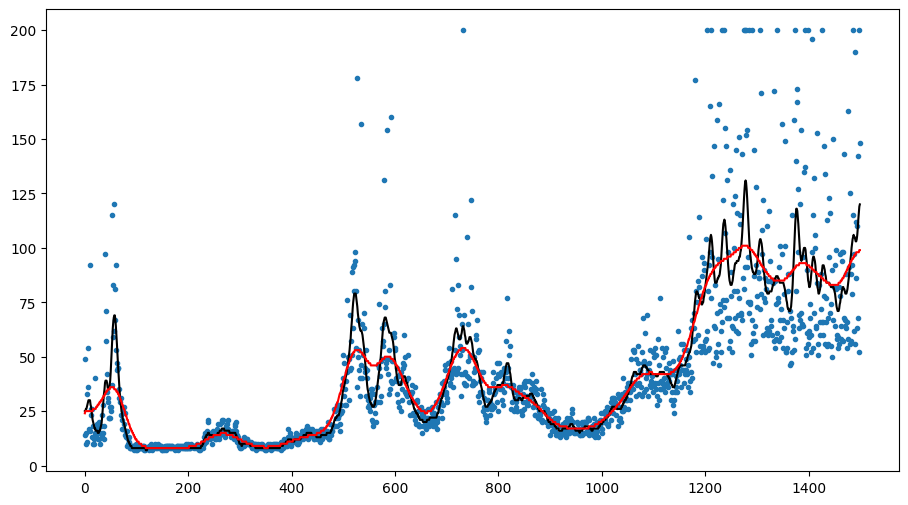

In [ ]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d  ## for smoothing
%matplotlib inline

# ysmoothed = gaussian_filter1d(y, sigma=2)
# plt.plot(x, ysmoothed)
# plt.show()
x = range(len(set_of_ep_lens))
y = set_of_ep_lens
y_smoothed = gaussian_filter1d(y, sigma=4)
y_smoothed_high = gaussian_filter1d(y, sigma=20)
plt.figure(figsize=(11,6))
plt.plot(x, y, '.')
plt.plot(x, y_smoothed, 'k')
plt.plot(x, y_smoothed_high, 'r')

plt.show
# plt.ylabel(set_of_ep_lens)
# plt.plot

In [ ]:
'''Testing model'''
# Using the policy network to sample an action
testing_state = env.reset()[0]
output_prob = model(torch.from_numpy(testing_state).float())
nn_action = np.random.choice(np.array([0,1]), p = output_prob.data.numpy()) ### .data gives the numbers of pred and removes other strings like Tensor
state_new, reward, done, info, dic = env.step(nn_action)

print(testing_state, '\n',output_prob, '\n', nn_action, '\n', state_new, reward, done, info, dic)

[-0.01615289  0.034036   -0.01844477 -0.04161617] 
 tensor([1., 0.], grad_fn=<SoftmaxBackward0>) 
 0 
 [-0.01547217 -0.16081667 -0.01927709  0.24519067] 1.0 False False {}


In [ ]:
# '''Saving'''
# torch.save(model.state_dict(), 'Reinforce_model_torch_nn_200_times_3500_episodes.pt')